# 评估同化算法的性能


In [1]:
%load_ext autoreload
%autoreload 2

## 基本参数设置

In [36]:
# Depending on your combination of package versions, this can raise a lot of TF warnings... 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
# import torch
# import seaborn as sns
from pathlib import Path
import pickle
import sys 
sys.path.append('../')

In [3]:
!ls /public/home/wangwuxing01/research/fundation/output

da_cycle  forecast  medium_forecast


In [4]:
da_cycle_dir = "/public/home/wangwuxing01/research/fundation/output_npj/da_cycle"
medium_forecast_dir = "/public/home/wangwuxing01/research/fundation/output_npj/medium_forecast"
scaler_dir = "/public/home/wangwuxing01/research/fundation/data/era5_6_hourly/assim_dir_3day/scaler.pkl"
var_idx_dir = "/public/home/wangwuxing01/research/fundation/data/era5_6_hourly/assim_dir_3day/var_idx.npy"

In [5]:
var_idx = [k for k in np.load(var_idx_dir)]

In [6]:
plot_vars = ["Z", "T", "R", "U"]
unit_y = ["(m$^2$ s$^{-2}$)", "(K)", "(%)", "(m s$^{-1}$)"]
plot_idx = [1, 10, 22, 20, 21, 23, 9, 5, 13, 17]

In [7]:
tmp = xr.open_mfdataset("/public/home/wangwuxing01/research/fundation/data/era5_6_hourly/obs_r_2010.nc", 
                  combine="by_coords", parallel=True)

In [8]:
lat, lon = tmp.latitude.values, tmp.longitude.values

In [9]:
idx = 39

In [10]:
xb = np.load(f"{da_cycle_dir}/xb_3day.npy")[idx].astype(np.float32)

xa_dacycle_4dvarnet = np.load(f"{da_cycle_dir}/assim_4dvarnet_obs[20, 21]_xb_3day.npy")[idx, 0].astype(np.float32)
xa_dacycle_vit = np.load(f"{da_cycle_dir}/assim_vit_obs[20, 21]_xb_3day.npy")[idx, 0].astype(np.float32)
xa_dacycle_4dvarformer = np.load(f"{da_cycle_dir}/assim_4dvarformer_obs[20, 21]_xb_3day.npy")[idx, 0].astype(np.float32)

xt = np.load(f"{da_cycle_dir}/real_xb_3day.npy")[idx, 0].astype(np.float32)

In [11]:
dx_4dvarnet = xa_dacycle_4dvarnet - xb
dx_vit = xa_dacycle_vit - xb
dx_4dvarformer = xa_dacycle_4dvarformer - xb

In [12]:
vis_xb = [xb[1] - xt[1], xb[2] - xt[2], xb[20] - xt[20], xb[21] - xt[21]]
vis_4dvarnet = [dx_4dvarnet[1], dx_4dvarnet[2], dx_4dvarnet[20], dx_4dvarnet[21]]
vis_vit = [dx_vit[1], dx_vit[2], dx_vit[20], dx_vit[21]]
vis_4dvarformer = [dx_4dvarformer[1], dx_4dvarformer[2], dx_4dvarformer[20], dx_4dvarformer[21]]
vis = [vis_4dvarnet, vis_vit, vis_4dvarformer]
vlim = [[-1000, 1000], [-1300, 1300], [-25, 25], [-25, 25]]

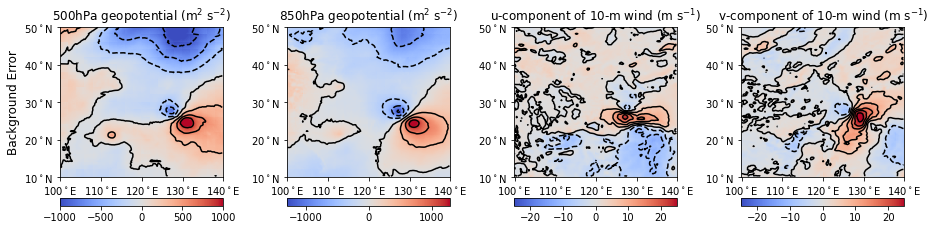

In [17]:
ylables = ["Background Error"]
titles = ["500hPa geopotential (m$^2$ s$^{-2}$)", 
           "850hPa geopotential (m$^2$ s$^{-2}$)", 
           "u-component of 10-m wind (m s$^{-1}$)", 
           "v-component of 10-m wind (m s$^{-1}$)"]

fig, axes = plt.subplots(1, 4, figsize=(13, 3.3))
for j in range(4):
    axes[j].set_title(titles[j], fontsize=12)
    im = axes[j].pcolormesh(lon[:-1], lat[:-1], vis_xb[j], cmap="coolwarm", vmin=vlim[j][0], vmax=vlim[j][1])
    axes[j].contour(lon[:-1], lat[:-1], vis_xb[j], colors="black")
    axes[j].set_xticks([100, 110, 120, 130, 140])
    axes[j].set_xticklabels(["{}$^\circ$E".format(x) if  x > 0 else "{}$^\circ$W".format(np.abs(x)) for x in axes[j].get_xticks()])
    axes[j].set_yticks([10, 20, 30, 40, 50])
    axes[j].set_yticklabels(["{}$^\circ$N".format(y) if y > 0 else "{}$^\circ$S".format(np.abs(y)) for y in axes[j].get_yticks()])
    if j == 0:
        label = axes[j].set_ylabel(ylables[0], fontsize=12)
    divider = make_axes_locatable(axes[j])
    cax = divider.append_axes("bottom", size="5%", pad="14%")
    fig.colorbar(im, cax=cax, orientation="horizontal")
                    
plt.tight_layout()
plt.savefig(f'xb_err_wind.jpg',dpi=300)
plt.savefig(f'xb_err_wind.pdf',dpi=300)
plt.show()

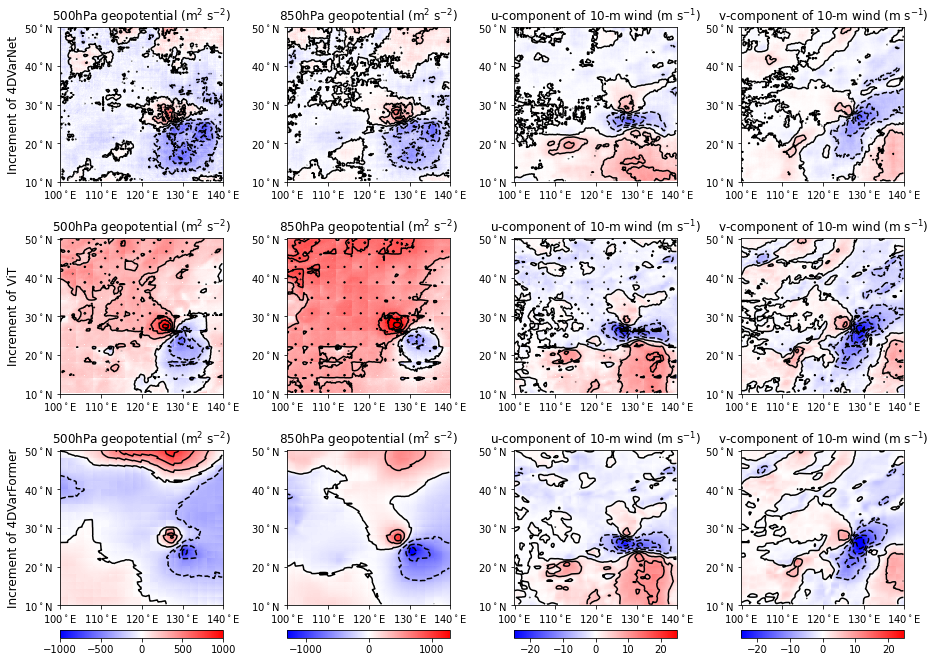

In [45]:
ylables = ["Increment of 4DVarNet", "Increment of ViT", "Increment of 4DVarFormer"]
titles = ["500hPa geopotential (m$^2$ s$^{-2}$)", 
           "850hPa geopotential (m$^2$ s$^{-2}$)", 
           "u-component of 10-m wind (m s$^{-1}$)", 
           "v-component of 10-m wind (m s$^{-1}$)"]

fig, axes = plt.subplots(3, 4, figsize=(13, 9.3))
for i in range(3):
    for j in range(4):
        axes[i, j].set_title(titles[j], fontsize=12)
        im = axes[i, j].pcolormesh(lon[:-1], lat[:-1], vis[i][j], cmap="bwr", vmin=vlim[j][0], vmax=vlim[j][1])
        axes[i, j].contour(lon[:-1], lat[:-1], vis[i][j], colors="black")
        axes[i, j].set_xticks([100, 110, 120, 130, 140])
        axes[i, j].set_xticklabels(["{}$^\circ$E".format(x) if  x > 0 else "{}$^\circ$W".format(np.abs(x)) for x in axes[i,j].get_xticks()])
        axes[i, j].set_yticks([10, 20, 30, 40, 50])
        axes[i, j].set_yticklabels(["{}$^\circ$N".format(y) if y > 0 else "{}$^\circ$S".format(np.abs(y)) for y in axes[i,j].get_yticks()])
        if (4 *i + j) in [0, 4, 8]:
            label = axes[i, j].set_ylabel(ylables[i], fontsize=12)
        if (4 *i + j) in [8, 9, 10, 11]:
            divider = make_axes_locatable(axes[i, j])
            cax = divider.append_axes("bottom", size="5%", pad="16%")
            fig.colorbar(im, cax=cax, orientation="horizontal")
        else:
            divider = make_axes_locatable(axes[i, j])
            cax = divider.append_axes("bottom", size="5%", pad="16%")
            cax.set_visible(False)
            
# plt.subplots_adjust(bottom=0.85)
plt.tight_layout()
plt.savefig(f'increment_wind.jpg',dpi=300)
plt.savefig(f'increment_wind.pdf',dpi=300)
plt.show()

In [46]:
xa_dacycle_4dvarnet = np.load(f"{da_cycle_dir}/assim_4dvarnet_obs[8, 9, 10, 11]_xb_3day.npy")[idx, 0].astype(np.float32)
xa_dacycle_vit = np.load(f"{da_cycle_dir}/assim_vit_obs[8, 9, 10, 11]_xb_3day.npy")[idx, 0].astype(np.float32)
xa_dacycle_4dvarformer = np.load(f"{da_cycle_dir}/assim_4dvarformer_obs[8, 9, 10, 11]_xb_3day.npy")[idx, 0].astype(np.float32)

In [47]:
dx_4dvarnet = xa_dacycle_4dvarnet - xb
dx_vit = xa_dacycle_vit - xb
dx_4dvarformer = xa_dacycle_4dvarformer - xb

In [48]:
vis_xb = [xb[5] - xt[5], xb[9] - xt[9], xb[6] - xt[6], xb[10] - xt[10]]
vis_4dvarnet = [dx_4dvarnet[5], dx_4dvarnet[9], dx_4dvarnet[6], dx_4dvarnet[10]]
vis_vit = [dx_vit[5], dx_vit[9], dx_vit[6], dx_vit[10]]
vis_4dvarformer = [dx_4dvarformer[5], dx_4dvarformer[9], dx_4dvarformer[6], dx_4dvarformer[10]]
vis = [vis_4dvarnet, vis_vit, vis_4dvarformer]
vlim = [[-100, 100], [-4.5, 4.5], [-55, 55], [-15, 15]]

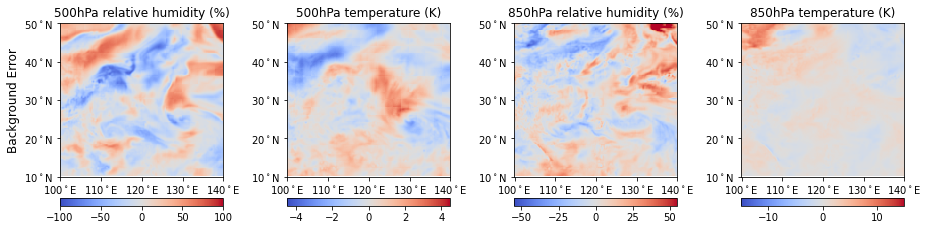

In [52]:
ylables = ["Background Error"]
titles = ["500hPa relative humidity (%)", 
          "500hPa temperature (K)", 
           "850hPa relative humidity (%)", 
          "850hPa temperature (K)"]

fig, axes = plt.subplots(1, 4, figsize=(13, 3.3))
for j in range(4):
    axes[j].set_title(titles[j], fontsize=12)
    im = axes[j].pcolormesh(lon[:-1], lat[:-1], vis_xb[j], cmap="coolwarm", vmin=vlim[j][0], vmax=vlim[j][1])
    # axes[j].contour(lon[:-1], lat[:-1], vis_xb[j], colors="black")
    axes[j].set_xticks([100, 110, 120, 130, 140])
    axes[j].set_xticklabels(["{}$^\circ$E".format(x) if  x > 0 else "{}$^\circ$W".format(np.abs(x)) for x in axes[j].get_xticks()])
    axes[j].set_yticks([10, 20, 30, 40, 50])
    axes[j].set_yticklabels(["{}$^\circ$N".format(y) if y > 0 else "{}$^\circ$S".format(np.abs(y)) for y in axes[j].get_yticks()])
    if j == 0:
        label = axes[j].set_ylabel(ylables[0], fontsize=12)
    divider = make_axes_locatable(axes[j])
    cax = divider.append_axes("bottom", size="5%", pad="14%")
    fig.colorbar(im, cax=cax, orientation="horizontal")
                    
plt.tight_layout()
plt.savefig(f'xb_err_temp.jpg',dpi=300)
plt.savefig(f'xb_err_temp.pdf',dpi=300)
plt.show()

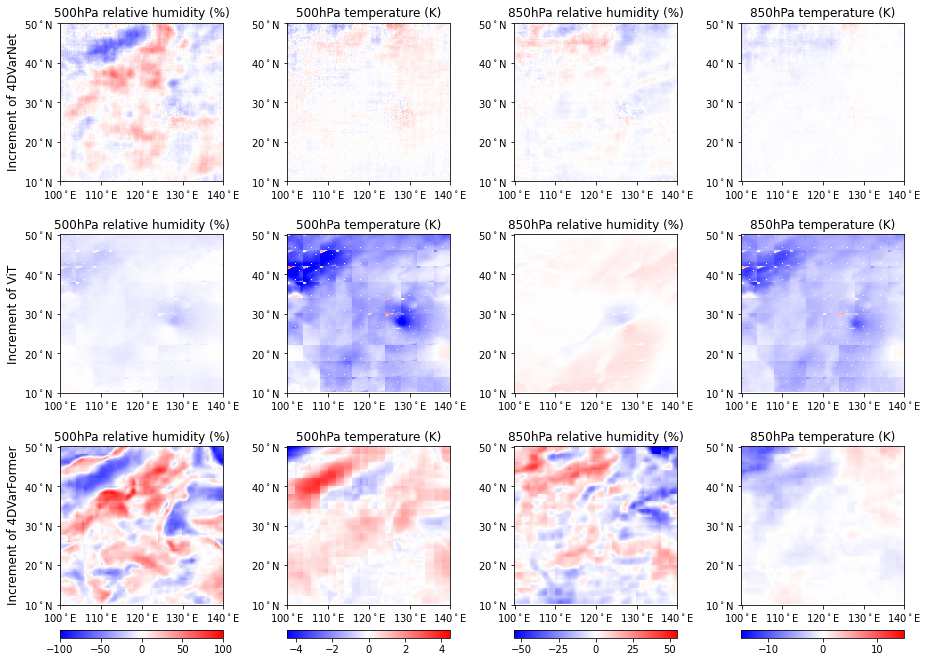

In [53]:
ylables = ["Increment of 4DVarNet", "Increment of ViT", "Increment of 4DVarFormer"]
titles = ["500hPa relative humidity (%)", 
          "500hPa temperature (K)", 
           "850hPa relative humidity (%)", 
          "850hPa temperature (K)"]

fig, axes = plt.subplots(3, 4, figsize=(13, 9.3))
for i in range(3):
    for j in range(4):
        axes[i, j].set_title(titles[j], fontsize=12)
        im = axes[i, j].pcolormesh(lon[:-1], lat[:-1], vis[i][j], cmap="bwr", vmin=vlim[j][0], vmax=vlim[j][1])
        # axes[i, j].contour(lon[:-1], lat[:-1], vis[i][j], colors="black")
        axes[i, j].set_xticks([100, 110, 120, 130, 140])
        axes[i, j].set_xticklabels(["{}$^\circ$E".format(x) if  x > 0 else "{}$^\circ$W".format(np.abs(x)) for x in axes[i,j].get_xticks()])
        axes[i, j].set_yticks([10, 20, 30, 40, 50])
        axes[i, j].set_yticklabels(["{}$^\circ$N".format(y) if y > 0 else "{}$^\circ$S".format(np.abs(y)) for y in axes[i,j].get_yticks()])
        if (4 *i + j) in [0, 4, 8]:
            label = axes[i, j].set_ylabel(ylables[i], fontsize=12)
        if (4 *i + j) in [8, 9, 10, 11]:
            divider = make_axes_locatable(axes[i, j])
            cax = divider.append_axes("bottom", size="5%", pad="16%")
            fig.colorbar(im, cax=cax, orientation="horizontal")
        else:
            divider = make_axes_locatable(axes[i, j])
            cax = divider.append_axes("bottom", size="5%", pad="16%")
            cax.set_visible(False)
                    
plt.tight_layout()
plt.savefig(f'increment_temp.jpg',dpi=300)
plt.savefig(f'increment_temp.pdf',dpi=300)
plt.show()